# Handwritten Digit Recognition

In this notebook, I will be training a CNN that recognize handwritten digit based off MNIST dataset.

**Steps**
1. Package
2. Load Dataset
3. Define Model
4. Train Model
5. Result

## Package

In [53]:
import torch
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import cv2

## Load Dataset

Load MNIST dataset using pytorch dataset.

In [54]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=v2.ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

tensor(4)


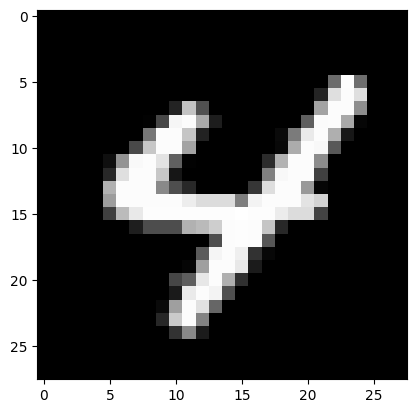

In [55]:
train_features, train_labels = next(iter(train_dataloader))

print(train_labels[0])
plt.imshow(torch.reshape(train_features[0], (28, 28)), cmap='gray')

## Define Model

Defining a CNN model that is similar to LeNet-5 architecture.

In [67]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding='same')
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(32, 32, 5, padding='same')
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv4.weight)
        self.fc1 = nn.Linear(3136, 256)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(256, 10)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

def cnn_loss(pred, target):

    # Perform crossentropy loss on every 10 units batch
    loss_fn = nn.NLLLoss()

    return loss_fn(pred, target)

In [68]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [69]:
# Train using GPU
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## Train Model

Train the CNN with custom early stopping.

In [70]:
ALPHA=0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=ALPHA)

def train_step(epoch_idx, model, loss_fn):
    for idx, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        running_loss = 0
        running_vloss = 0
        for idx, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = loss_fn(pred, labels)
            running_loss += loss

        avg_loss = running_loss / (idx + 1)
        
        for idx, data in enumerate(test_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            vloss = loss_fn(pred, labels)
            running_vloss += vloss
            
        avg_vloss = running_vloss / (idx + 1)
    
        print(f"Epoch {epoch_idx}:\nTraining Loss: {avg_loss}\nTest Loss: {avg_vloss}") 
        
    return avg_loss, avg_vloss

In [71]:
EARLY_STOP = 5
losses = []
vlosses = []

early_stopping_cnt = 0

mn = 10000

cnn.train()

for i in range(30):
    loss, vloss = train_step(i, cnn, cnn_loss)
    
    if vloss < mn:
        mn = vloss
        early_stopping_cnt = 0
    else:
        early_stopping_cnt += 1

    if early_stopping_cnt == EARLY_STOP:
        break
    
    losses.append(loss)
    vlosses.append(vloss)

Epoch 0:
Training Loss: 0.057304371148347855
Test Loss: 0.0564456470310688
Epoch 1:
Training Loss: 0.04751325771212578
Test Loss: 0.047439128160476685
Epoch 2:
Training Loss: 0.03963277116417885
Test Loss: 0.03788864612579346
Epoch 3:
Training Loss: 0.04937751218676567
Test Loss: 0.05037164315581322
Epoch 4:
Training Loss: 0.02931932546198368
Test Loss: 0.030061936005949974
Epoch 5:
Training Loss: 0.02935880981385708
Test Loss: 0.030794253572821617
Epoch 6:
Training Loss: 0.03741145133972168
Test Loss: 0.035905029624700546
Epoch 7:
Training Loss: 0.024042394012212753
Test Loss: 0.024308346211910248
Epoch 8:
Training Loss: 0.028307339176535606
Test Loss: 0.02762155793607235
Epoch 9:
Training Loss: 0.036923713982105255
Test Loss: 0.03501663729548454
Epoch 10:
Training Loss: 0.02997036837041378
Test Loss: 0.029314739629626274
Epoch 11:
Training Loss: 0.02801148220896721
Test Loss: 0.02855886146426201
Epoch 12:
Training Loss: 0.02073473297059536
Test Loss: 0.021931568160653114
Epoch 13:
Tr

## Result

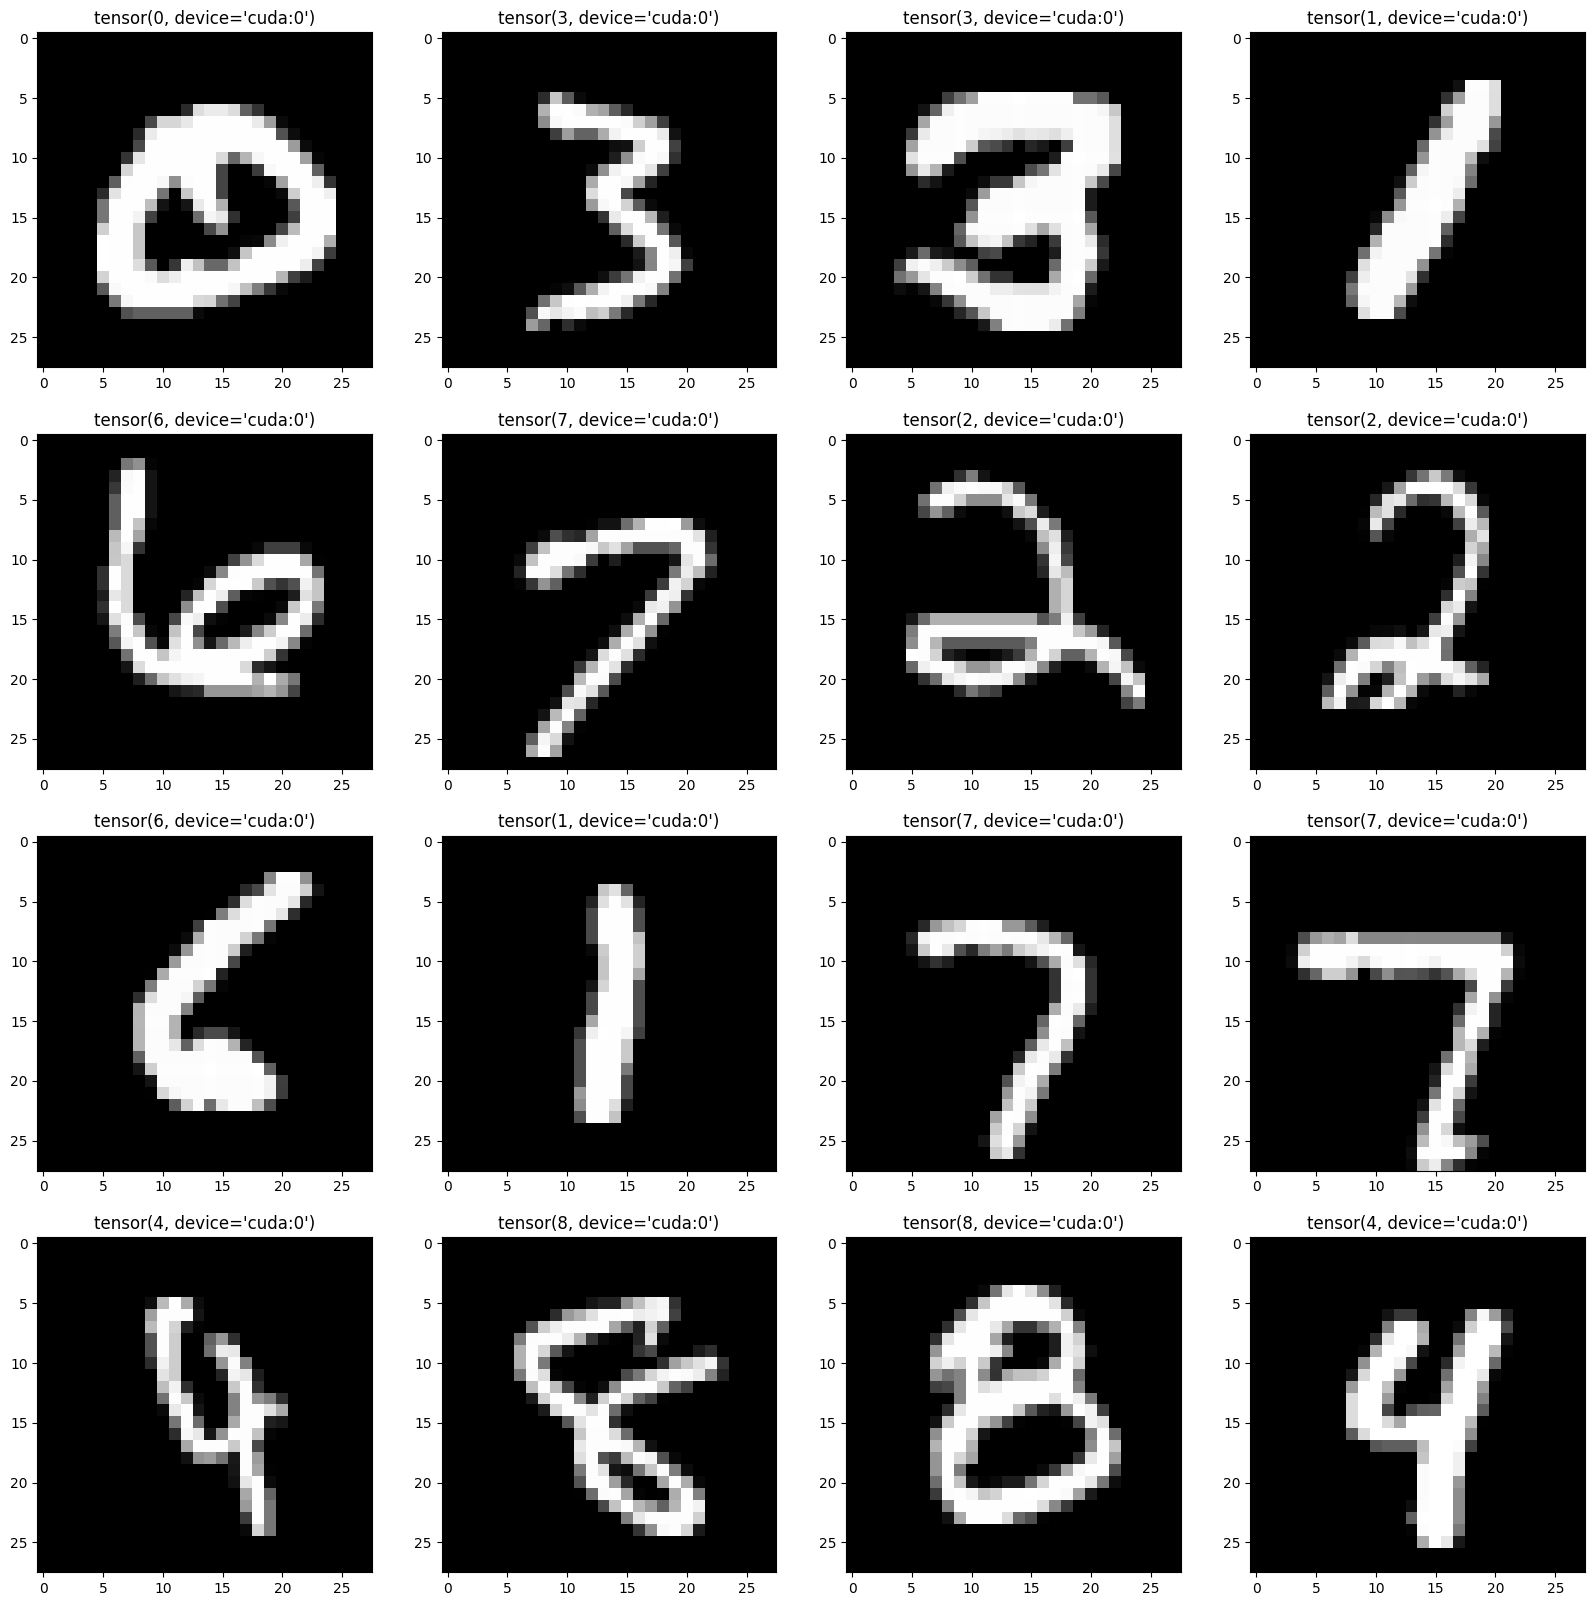

In [72]:
test_features, test_labels = next(iter(test_dataloader))

cnn.eval()

pred = cnn(test_features.to('cuda'))

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i in range(4):
    for j in range(4):
        axes[i, j].imshow(torch.reshape(test_features[i*4 + j], (28, 28)), cmap='gray')
        axes[i, j].set_title(torch.argmax(pred[i*4 + j]))

In [74]:
total = 0
right = 0
for idx, data in enumerate(test_dataloader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    pred = cnn(inputs)
    pred = torch.argmax(pred, dim=1)
    right += torch.sum(pred == labels)
    total += len(pred)

In [75]:
right/total * 100

tensor(99.8167, device='cuda:0')

This CNN achieve 99.81% accuracy on the MNIST dataset which is pretty good.

## Save parameters

In [76]:
torch.save(cnn.state_dict(), 'model')

## Some testing code

tensor(5, device='cuda:0')


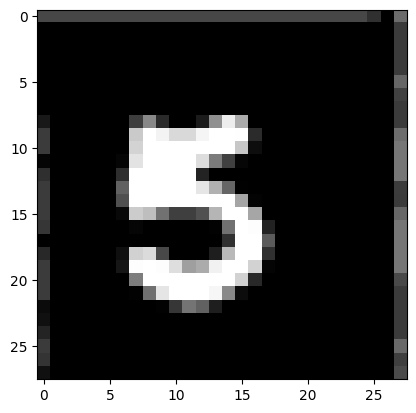

In [115]:
import torchvision
import cv2

im = cv2.imread('test2.png')

im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

im = cv2.adaptiveThreshold(im,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)

digit = cv2.resize(im, (28, 28), interpolation = cv2.INTER_AREA)

plt.imshow(digit, cmap='gray')

digit = torch.from_numpy(digit).float().to(device)

digit = digit.float().to(device)

digit /= 255

digit = digit[None, None, :, :]

print(torch.argmax(cnn(digit)))